(connectivite-chapitre)=
# Connectivité fonctionnelle

<table>
  <tr>
    <td align="center">
      <a href="https://github.com/sangfrois">
        <img src="https://avatars.githubusercontent.com/u/38385719?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>François Lespinasse</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
    </td>
    <td align="center">
      <a href="https://github.com/pbellec">
        <img src="https://avatars.githubusercontent.com/u/1670887?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Pierre bellec</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
    </td>
  </tr>
</table>

```{warning}
Ce chapitre est en cours de développement. Il se peut que l'information soit incomplète, ou sujette à changement.
```
## Objectifs du cours
Dans le chapitre sur les [cartes d'activation en IRMf](irm_fonctionnelle), nous avons vu que ce type d'analyse met l'emphase sur la notion de ségrégation fonctionnelle, c'est à dire à quel point certaines régions cérébrales sont engagées spécifiquement par une certaine catégorie de processus cognitifs. Mais il est bien connu que les processus cognitifs requièrent aussi un certain degré d'**intégration fonctionnelle**, où différentes régions du cerveau interagissent ensemble pour effectuer une tâche. Cette notion d'intégration amène à concevoir le cerveau comme un réseau, ou encore un graphe, qui décrit la **connectivité fonctionnelle** entre régions. Ce chapitre introduit des notions de base utilisées pour étudier la connectivité du cerveau à l'aide de l'IRMf.

```{figure} connectivite/brain-graph-fig.png
---
width: 400px
name: brain-graph-fig
---
Graphe de connectivité fonctionnelle moyen sur le jeu de données ADHD-200. Chaque noeud du graphe représente une région de cerveau, et les connexions représentent la connectivité fonctionnelle moyenne sur le jeu de données ADHD-200 {cite:p}`HD-200_Consortium2012-uv`, après seuillage. L'échelle de couleur et la taille des noeuds représentent le nombre de connexions (degré) associé à chaque noeud. Le graphe est généré à l'aide de la librairie [gephi](https://gephi.org/). La figure est tirée de {cite:p}`BELLEC2017275`, sous licence CC-BY.
```

Les objectifs spécifiques du chaptire sont de:
*   Comprendre la définition de la **connectivité fonctionnelle**.
*   Comprendre la distinction entre activité **intrinsèque** et **évoquée**.
*   Comprendre la notion de **réseau fonctionnel**.
*   Connaître les **principaux réseaux au repos**.


## Carte de connectivité fonctionnelle

/home/pbellec/env/psy3018/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Time series with shape (261, 122) (# time points, # parcels))


Time series with shape (261, 76297) (# time points, # voxels))


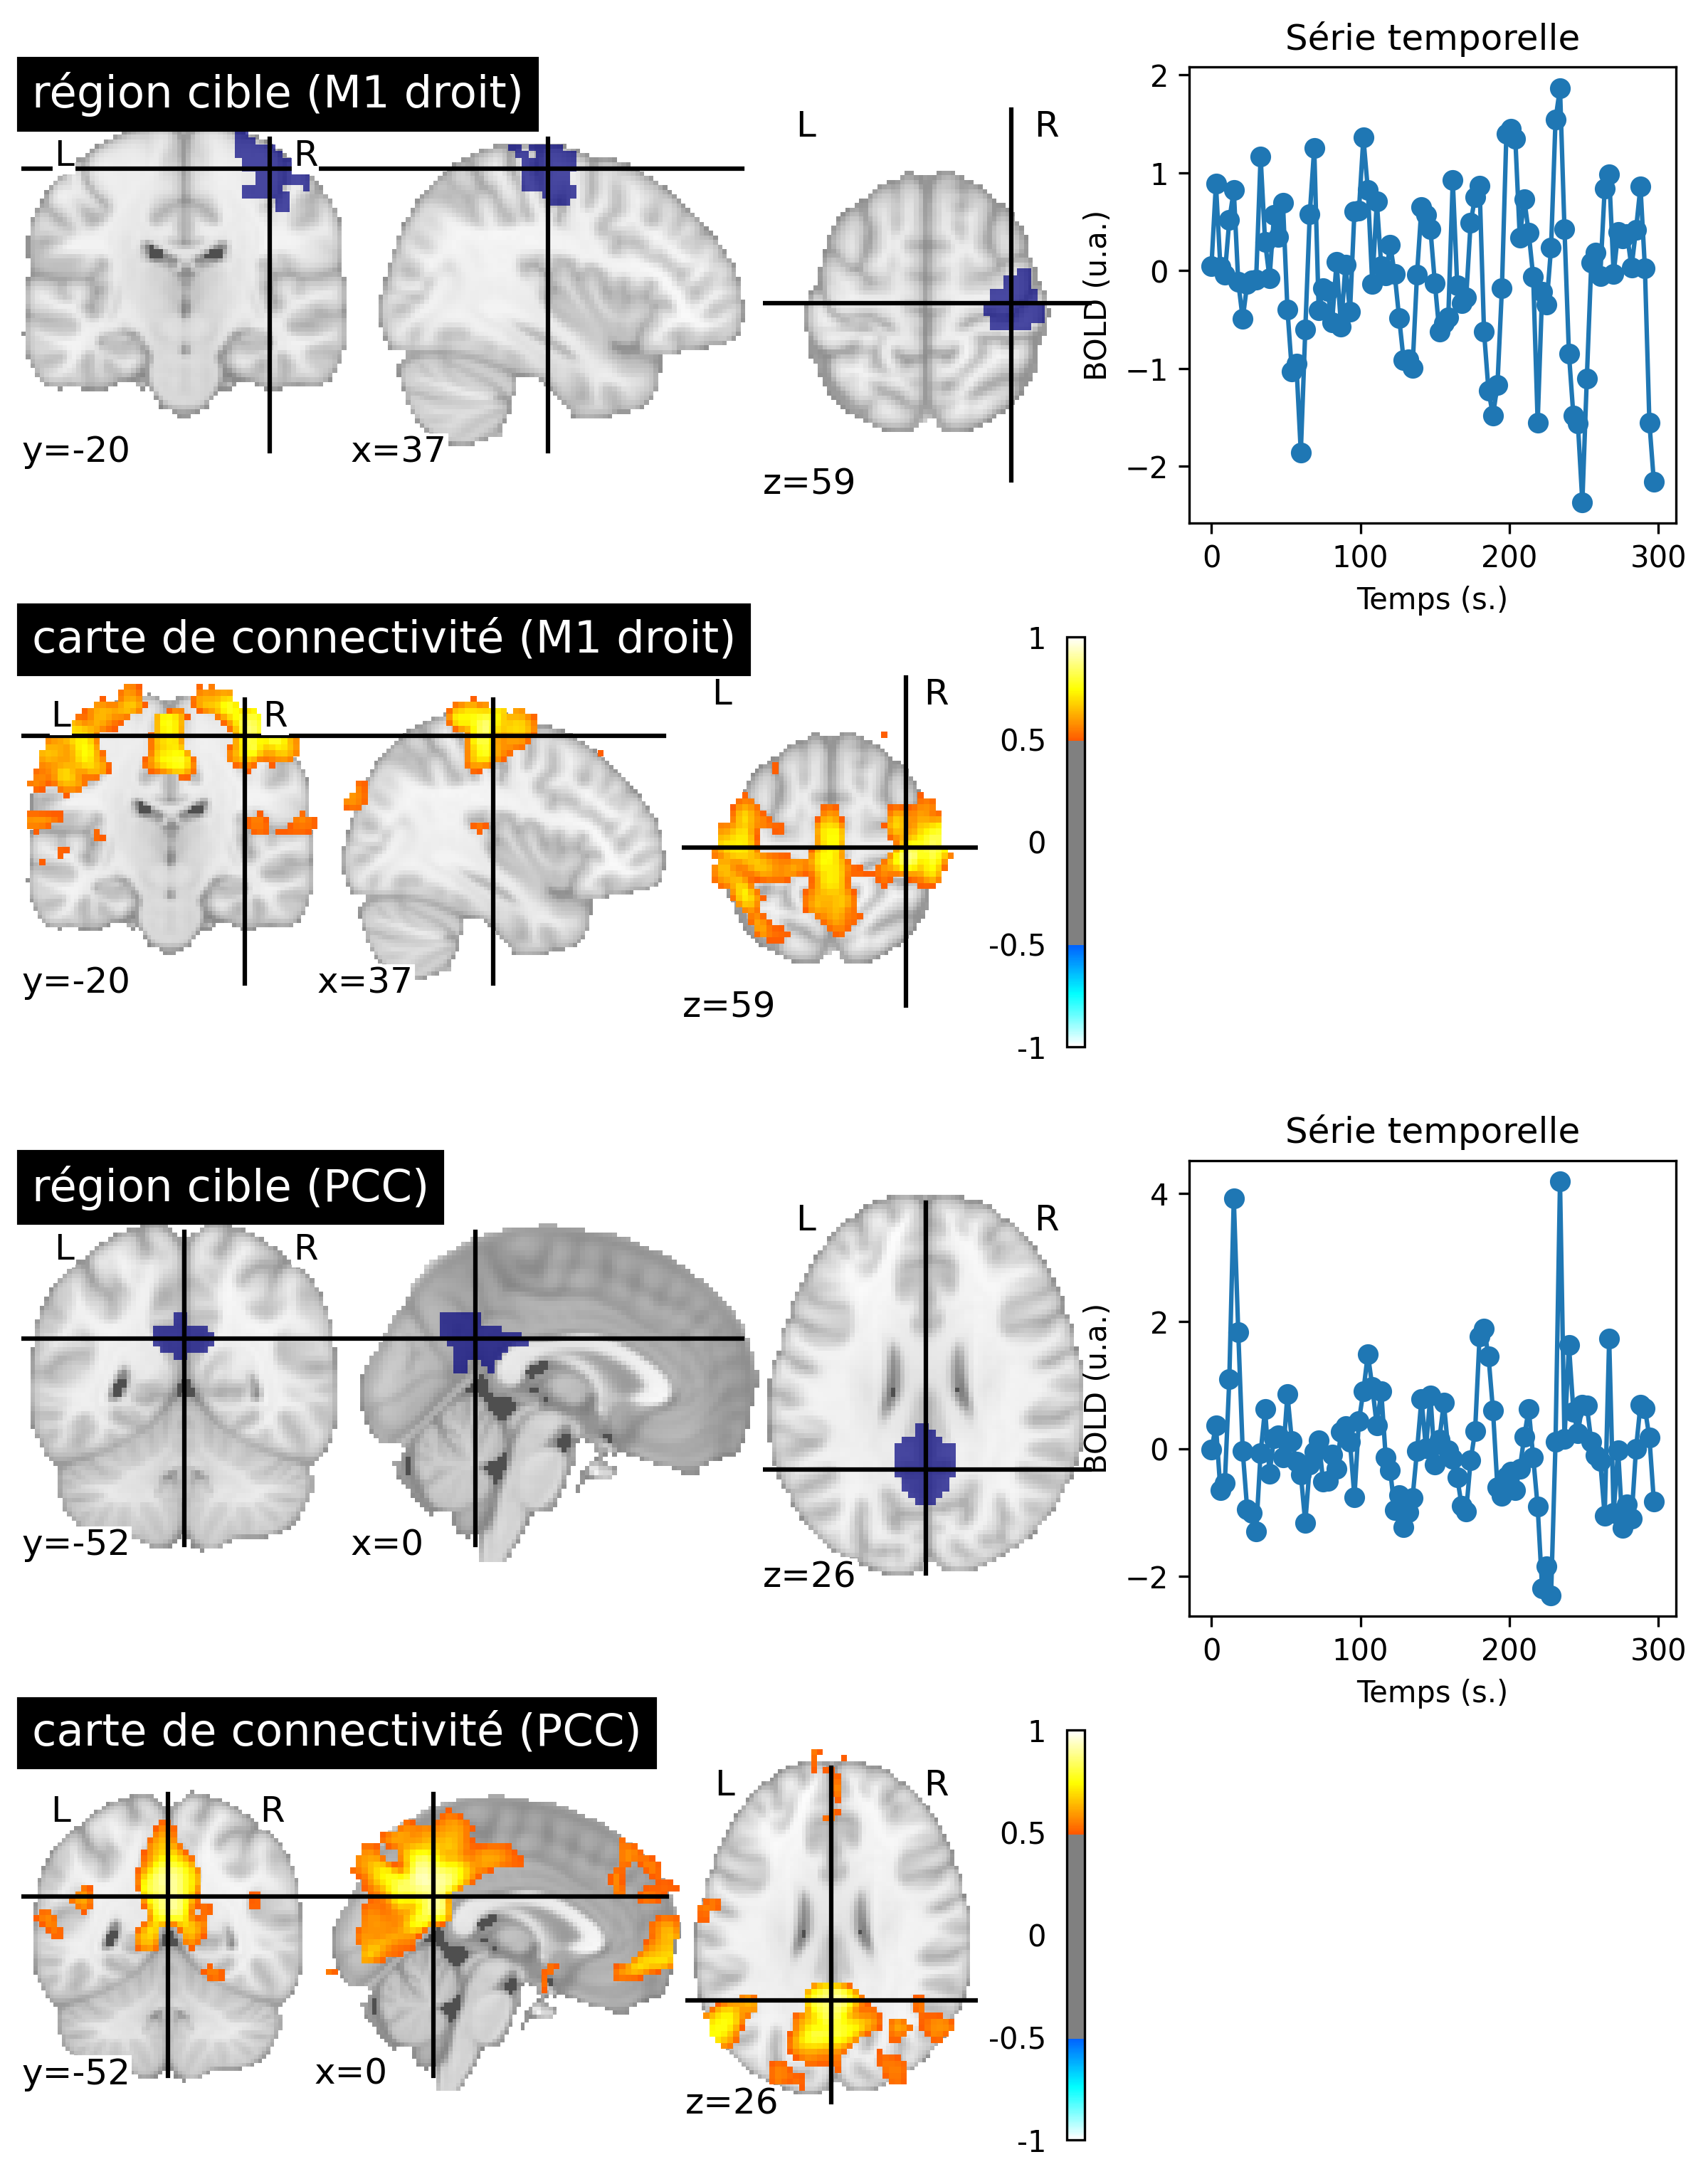

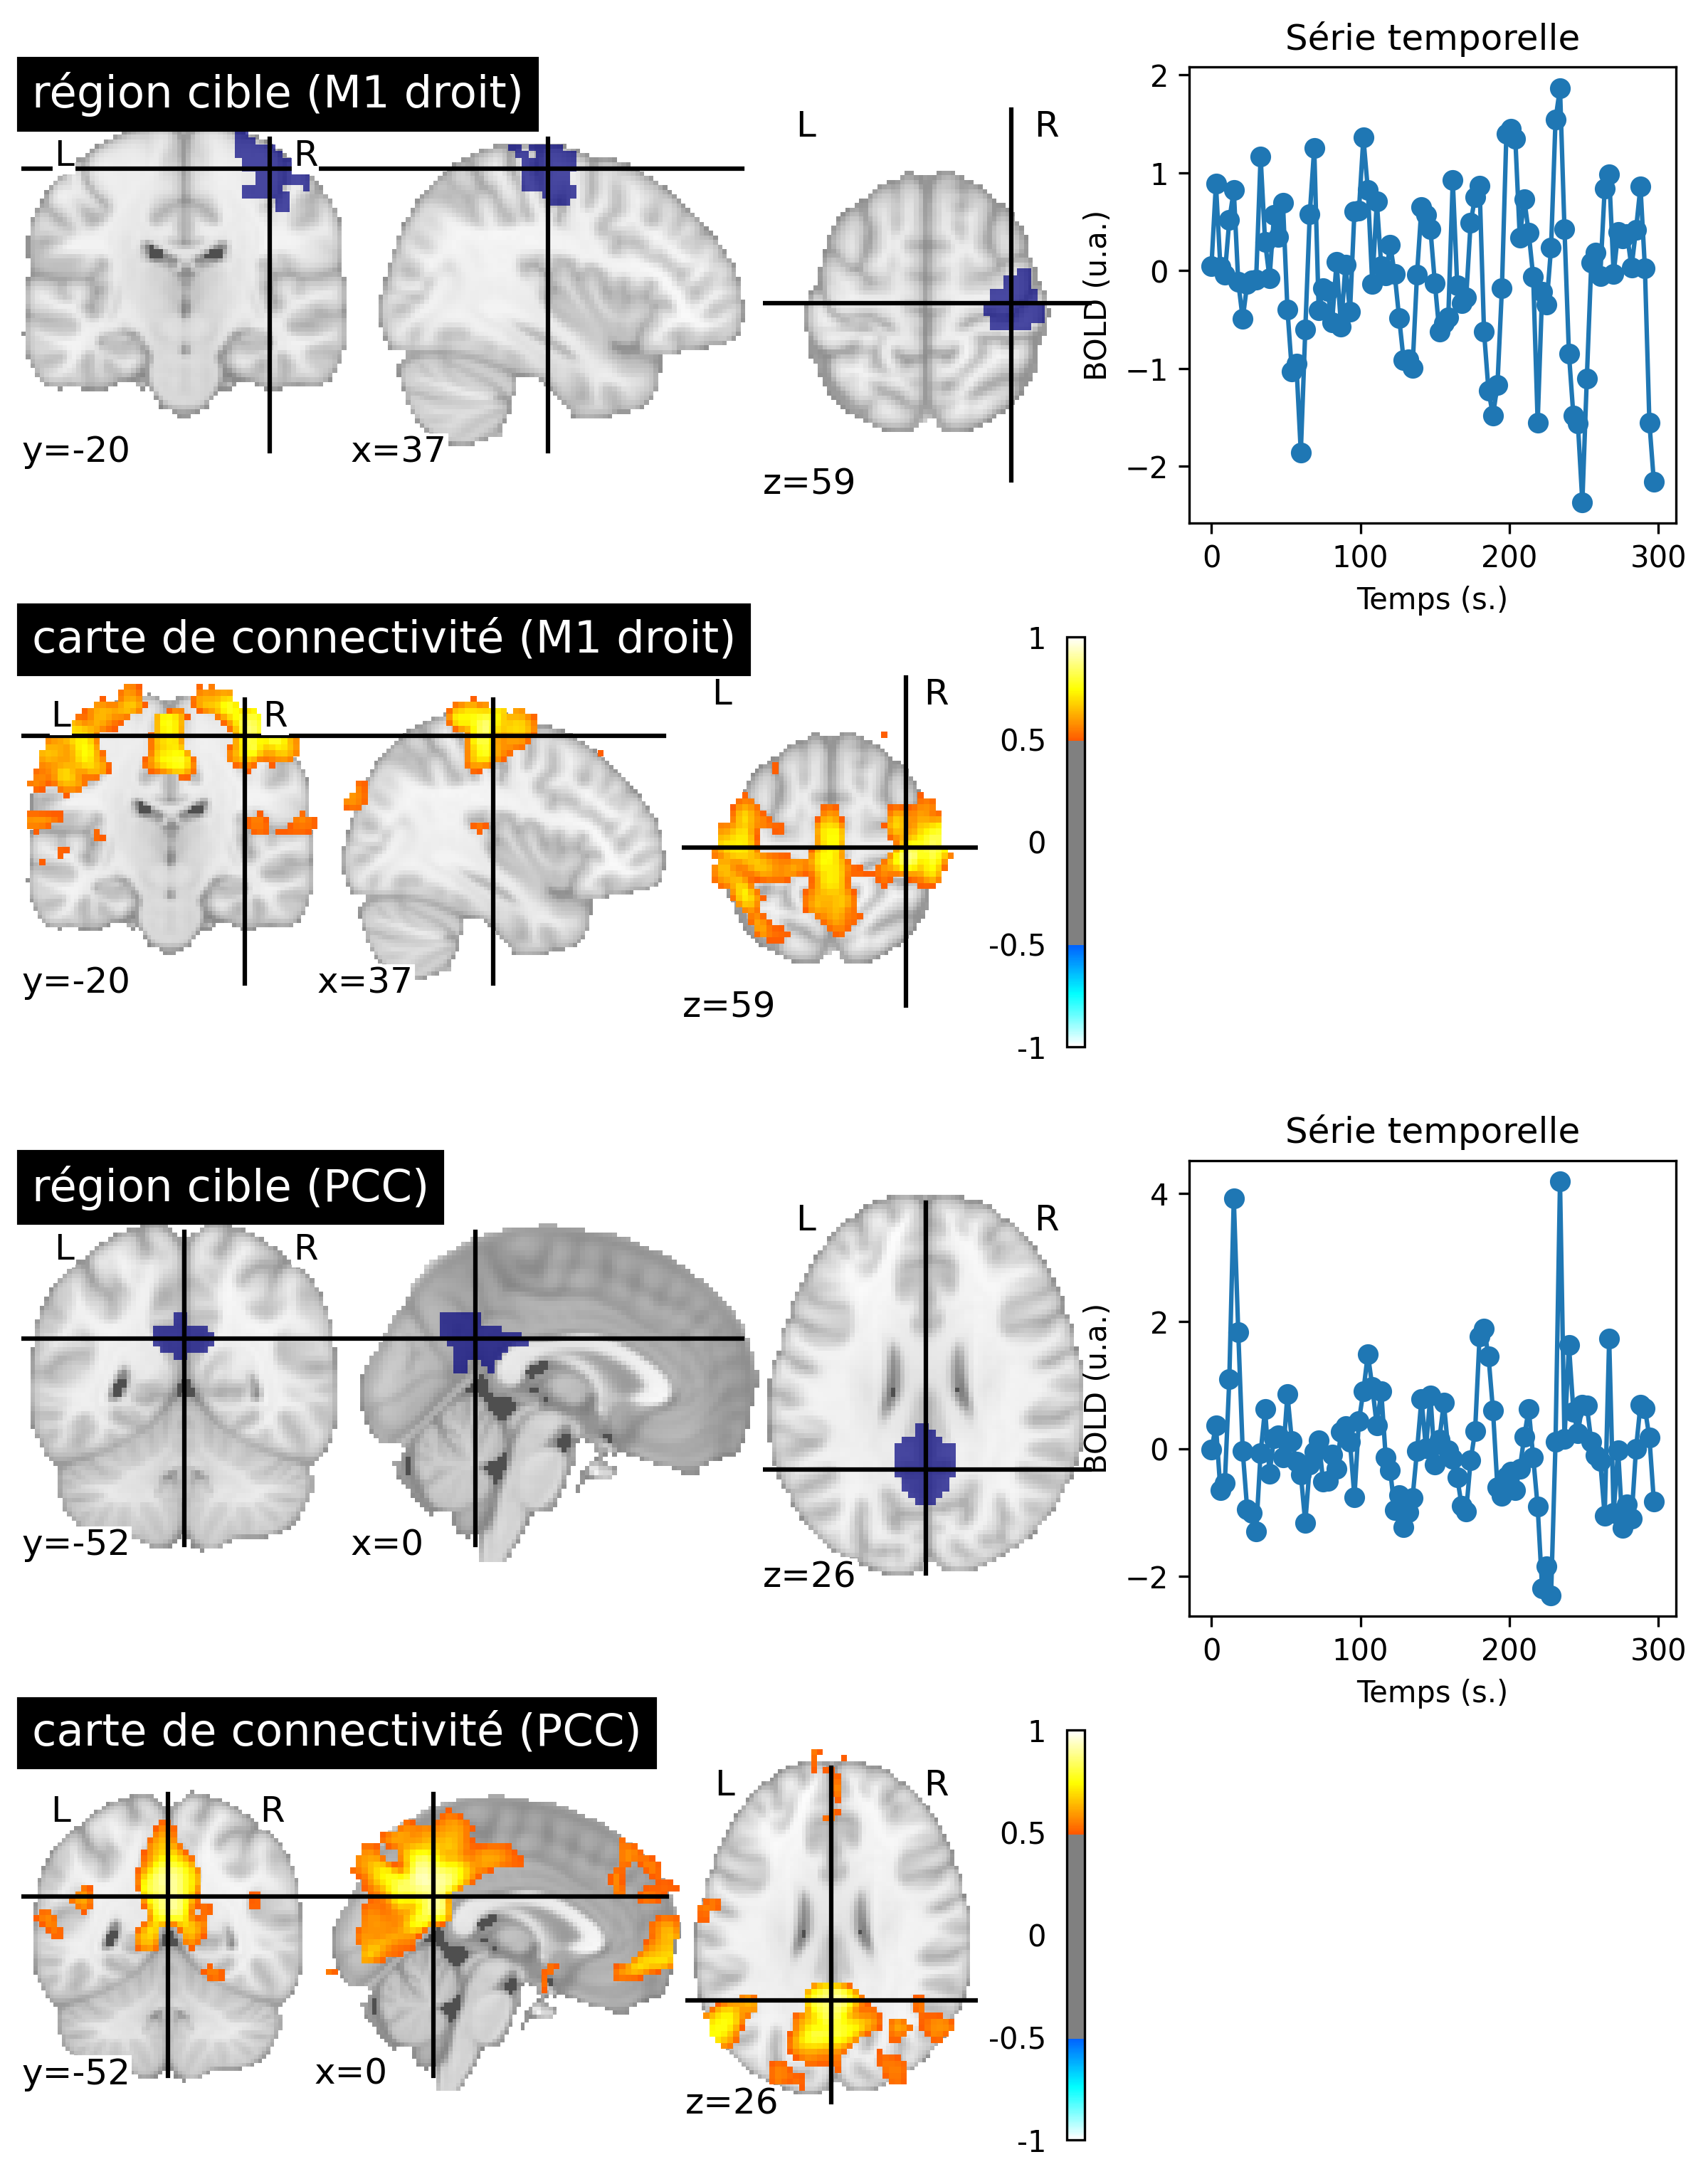

In [1]:
# Importe les librairies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image import math_img
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets # Fetch data using nilearn
from nilearn.input_data import NiftiMasker


import warnings
warnings.filterwarnings("ignore")

# Initialise la figure
fig = plt.figure(figsize=(10, 13), dpi=300)

# Importe les données
basc = datasets.fetch_atlas_basc_multiscale_2015() # the BASC multiscale atlas
adhd = datasets.fetch_adhd(n_subjects=10)          # ADHD200 preprocessed data (Athena pipeline)\

# Paramètres du pré-traitement
num_data = 6
fwhm = 8
high_pass = 0.01
high_variance_confounds = False
time_samp = range(0, 100)

# Extrait le signal par parcelle pour un atlas fonctionnel (BASC)
masker = input_data.NiftiLabelsMasker(
                                      basc['scale122'],
                                      resampling_target="data",
                                      high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      memory_level=1,
                                      smoothing_fwhm=fwhm).fit()
tseries = masker.transform(adhd.func[num_data])
print(f"Time series with shape {tseries.shape} (# time points, # parcels))")

# Charge les données par voxel
masker_voxel = input_data.NiftiMasker(high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      smoothing_fwhm=fwhm
                                     ).fit(adhd.func[num_data])
tseries_voxel = masker_voxel.transform(adhd.func[num_data])
print(f"Time series with shape {tseries_voxel.shape} (# time points, # voxels))")

# Montre une parcelle
ax_plot = plt.subplot2grid((4, 3), (0, 0), colspan=2)
num_parcel = 73
plotting.plot_roi(math_img(f'img == {num_parcel}', img=basc['scale122']),
                  threshold=0.5,
                  axes=ax_plot,
                  vmax=1,
                  title="région cible (M1 droit)")

# plot la série temporelle d'une région
ax_plot = plt.subplot2grid((4, 3), (0, 2), colspan=1)
time = np.linspace(0, 3 * (tseries.shape[0]-1), tseries.shape[0])
plt.plot(time[time_samp], tseries[time_samp, :][:, num_parcel], 'o-'),
plt.xlabel('Temps (s.)'),
plt.ylabel('BOLD (u.a.)')
plt.title('Série temporelle')

# carte de connectivité
ax_plot = plt.subplot2grid((4, 3), (1, 0), colspan=2)
seed_to_voxel_correlations = (np.dot(tseries_voxel.T, tseries[:, num_parcel-1]) / tseries.shape[0])# Show the connectivity map
conn_map = masker_voxel.inverse_transform(seed_to_voxel_correlations.T)
plotting.plot_stat_map(conn_map,
                       threshold=0.5,
                       vmax=1,
                       axes=ax_plot,
                       cut_coords=(37, -20, 59),
                       title="carte de connectivité (M1 droit)")

# Montre une parcelle
num_parcel = 17
ax_plot = plt.subplot2grid((4, 3), (2, 0), colspan=2)
plotting.plot_roi(math_img(f'img == {num_parcel}', img=basc['scale122']),
                  threshold=0.5,
                  vmax=1,
                  axes=ax_plot,
                  title="région cible (PCC)")

# plot la série temporelle d'une région
ax_plot = plt.subplot2grid((4, 3), (2, 2), colspan=1)
time = np.linspace(0, 3 * (tseries.shape[0]-1), tseries.shape[0])
plt.plot(time[time_samp], tseries[time_samp, :][:, num_parcel], 'o-'),
plt.xlabel('Temps (s.)'),
plt.ylabel('BOLD (u.a.)')
plt.title('Série temporelle')


# carte de connectivité
ax_plot = plt.subplot2grid((4, 3), (3, 0), colspan=2)
seed_to_voxel_correlations = (np.dot(tseries_voxel.T, tseries[:, num_parcel-1]) / tseries.shape[0])# Show the connectivity map
conn_map = masker_voxel.inverse_transform(seed_to_voxel_correlations.T)
plotting.plot_stat_map(conn_map,
                       threshold=0.5,
                       cut_coords=(0, -52, 26),
                       vmax=1,
                       axes=ax_plot,
                       title="carte de connectivité (PCC)")

from myst_nb import glue
glue("fcmri-map-fig", fig, display=False)

```{glue:figure} fcmri-map-fig
:figwidth: 600px
:name: fcmri-map-fig
:align: center
Cartes de connectivité au repos générées à partir des données IRMf d'un individu du jeu de données ADHD-200 {cite:p}`HD-200_Consortium2012-uv`. Pour chaque carte, la région cible utilisée ainsi que les cinq premières minutes d'activité BOLD associée à la région cible sont représentées. Cette figure est générée par du code python à l'aide de la librairie [nilearn](https://nilearn.github.io/) (cliquer sur + pour voir le code), et est distribuée sous licence CC-BY.
```

Avant de parler de connectivité fonctionnelle, revisitons le concept de cartes d'activation en IRMf. Comme nous l'{ref}`avons vu <activation-section>`, on génère une carte d'activation en comparant les fluctuations BOLD dans une région donnée du cerveau avec une prédiction de la réponse cérébrale associée à une tâche. De manière simplifiée, la carte d'activation nous montre la corrélation entre l'activité attendue (sur la base du paradigme expérimentale et d'une fonction de réponse hémodynamique) et l'activité mesurée à chaque voxel.

Une carte de connectivité relève un peu de la même logique. Mais au lieu de nous intéresser à la réponse attendue en réponse à une tâche, nous allons nous intéresser à l'activité d'une région particulière du cerveau, appelée **région cible**. Nous allons alors mesurer la corrélation entre le décours temporel de chaque voxel dans le cerveau et décours temporel de la région cible. Nous allons obtenir une **carte de connectivité fonctionnelle** qui nous montre quelles régions du cerveau ont une activité très corrélée (ou synchrone) avec la région cible.

```{admonition} Mesure de corrélation
:class: tip
:name: corrélation

La [corrélation](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)) entre deux séries temporelles est une mesure qui varie entre -1 et 1. Si les deux séries sont identiques (à leur moyenne et variance près), la corrélation est de 1. Si les deux séries sont statistiquement indépendantes, la corrélation est proche de zéro. Si les deux séries sont mirroirs l'une de l'autre, la corrélation est de -1.
```

Le concept de carte fonctionnelle a été introduit par Biswal et collègues (1995) {cite:p}`Biswal1995-lw`, en utilisant une cible dans le cortex sensorimoteur primaire droit. Cette région cible avait été obtenue avec une carte d'activation et une tâche motrice. Biswal et collègues ont alors eu l'idée d'observer les fluctuations BOLD dans une condition de **repos**, en l'absence de tâche expérimentale. Cette carte révèle un ensemble distribué de régions (voir {numref}`fcmri-map-fig`, cible M1 droit), qui comprend le cortex sensorimoteur gauche, mais aussi l'aire motrice supplémentaire, le cortex prémoteur et d'autres régions du cerveau connues pour leur implication dans le **réseau moteur**. Cette étude a tout d'abord engendré beaucoup de septicisme, au motif que ces patrons d'activité fonctionnelle corrélée aurait pu refléter du bruit cardiaque ou respiratoire.

```{admonition} Fluctuations lentes
:class: tip
:name: fluctuations-lentes
Une autre observation clé de Biswal et collègues (1995) {cite:p}`Biswal1995-lw` est que le signal BOLD au repos est dominé par des fluctuations lentes, avec des bouffées d'activité d'une durée de 20 à 30 secondes, clairement visibles dans la {numref}`fcmri-map-fig`. Plus spécifiquement, le spectre du signal BOLD au repos est dominée par les fréquences inférieures à 0.08 Hz, et même 0.03-0.05 Hz.
```
La crédibilité des cartes de connectivité au repos s'est renforcée quand différents groupes de recherche ont pu identifié d'autres réseaux en utilisant des régions cibles différentes, notamment le réseau visuel et le réseau auditif. Mais c'est l'étude de Greicis et collaborateurs, en 2003 {cite:p}`Greicius2003-hi`, qui a déclenché un énorme intérêt pour les cartes de connectivité au repos en utilisant une région cible dans le cortex cingulaire postérieur (PCC) pour identifier un réseau fonctionnel qui n'avait pas encore été identifié: le **réseau du mode par défaut** (voir {numref}`fcmri-map-fig`, cible PCC). Nous allons discuter dans la prochaine section des origines de ce réseau, et comment il peut nous aider à comprendre ce que mesure la connectivité au repos. Il est également important de mentionner que le travail de Shmuel et collèges (2008) {cite:p}`Shmuel2008-pa` a démontré que l'activité BOLD au repos corrèle aux fluctuations spontanées d'activité neuronales dans le cortex visuel d'un macaque anésthésié, ce qui démontre que la connectivité fonctionnelle reflète au moins partiellement la synchronie de l'activité neuronale, et pas simplement du bruit physiologique (cardiaque, respiration).

```{admonition} Variabilité intra- et inter-individuelle
:class: caution attention
:name: fcmri-map-warning
La {numref}`fcmri-map-fig` peut donner l'impression que les réseaux de connectivité sont extrêmement stables. En réalité, les cartes de connectivité varient beaucoup au cours du temps, c'est à dire en regardant différentes fenêtres d'activité pour un même individu, et également entre individus. Caractériser la variabilité intra- et inter-individuelle des cartes de connectivité est un domaine de recherche actif.
```
## Le réseau du mode par défaut

Time series with shape (176, 122) (# time points, # parcels))


Time series with shape (176, 71441) (# time points, # voxels))


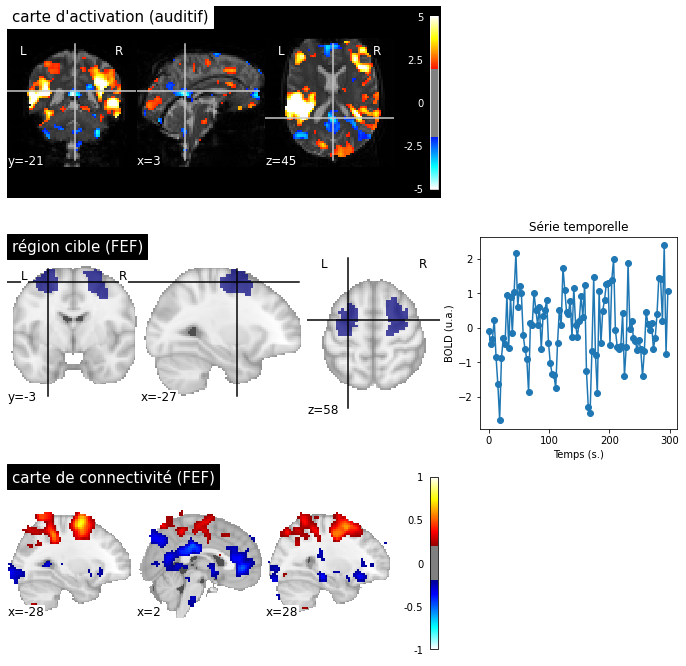

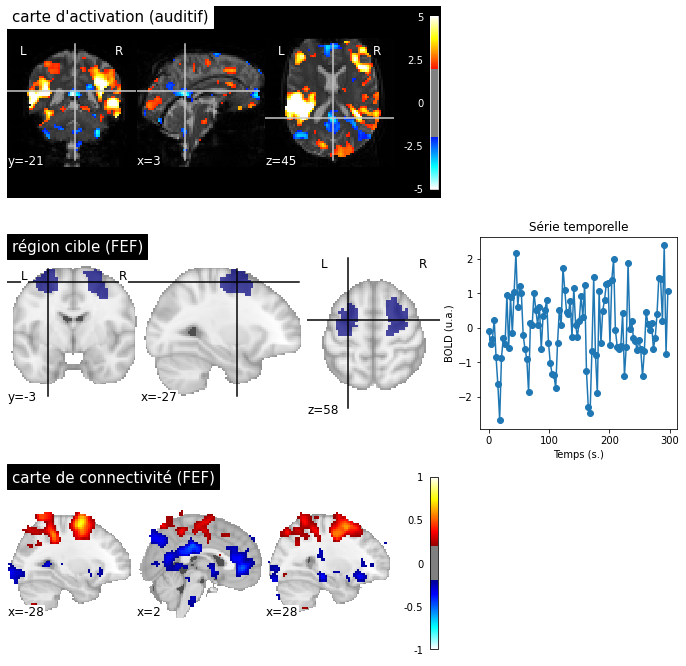

In [2]:
# Importe les librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import datasets
from nilearn.image import math_img
from nilearn import image
from nilearn import masking
from nilearn.glm.first_level import FirstLevelModel
from nilearn import input_data
from nilearn.input_data import NiftiLabelsMasker
from nilearn.input_data import NiftiMasker
from nilearn import plotting

# initialisation de la figure
fig = plt.figure(figsize=(12,12))

# load fMRI data
subject_data = datasets.fetch_spm_auditory()
fmri_img = image.concat_imgs(subject_data.func)

# Make an average
mean_img = image.mean_img(fmri_img)
mask = masking.compute_epi_mask(mean_img)

# Clean and smooth data
fmri_img = image.clean_img(fmri_img, high_pass=0.01, t_r=7, standardize=False)
fmri_img = image.smooth_img(fmri_img, 8.)

# load events
events = pd.read_table(subject_data['events'])

# Fit model
fmri_glm = FirstLevelModel(t_r=7,
                           drift_model='cosine',
                           signal_scaling=False,
                           mask_img=mask,                           
                           minimize_memory=False)

fmri_glm = fmri_glm.fit(fmri_img, events)

# Extract activation clusters
z_map = fmri_glm.compute_contrast('active - rest')

# Extract time series
coords = [(3., -21, 45)]
masker = input_data.NiftiSpheresMasker(coords)
real_timeseries = masker.fit_transform(fmri_img)
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])

# plot activation map
ax_plot = plt.subplot2grid((3, 3), (0, 0), colspan=2)
plotting.plot_stat_map(
        z_map, threshold=2, vmax=5, figure=fig,
        axes=ax_plot, colorbar=True, cut_coords=coords[0], bg_img=mean_img, title='carte d\'activation (auditif)')

# plot time series
# this is a bit too messy
# Commenting out but leaving code, as this may be worth revisiting
# ax_plot = plt.subplot2grid((3, 3), (0, 2), colspan=1)
# plt.plot(real_timeseries, c='b', lw=2)
# plt.plot(-predicted_timeseries, c='r', ls='--', lw=2)
# plt.xlabel('temps (TR)')
# plt.ylabel('intensité BOLD')

# Importe les données
basc = datasets.fetch_atlas_basc_multiscale_2015() # the BASC multiscale atlas
adhd = datasets.fetch_adhd(n_subjects=10)          # ADHD200 preprocessed data (Athena pipeline)\

# Paramètres du pré-traitement
num_data = 1
fwhm = 8
high_pass = 0.01
high_variance_confounds = False
time_samp = range(0, 100)

# Extrait le signal par parcelle pour un atlas fonctionnel (BASC)
masker = input_data.NiftiLabelsMasker(
                                      basc['scale122'],
                                      resampling_target="data",
                                      high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      memory_level=1,
                                      smoothing_fwhm=fwhm).fit()
tseries = masker.transform(adhd.func[num_data])
print(f"Time series with shape {tseries.shape} (# time points, # parcels))")

# Charge les données par voxel
masker_voxel = input_data.NiftiMasker(high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      smoothing_fwhm=fwhm
                                     ).fit(adhd.func[num_data])
tseries_voxel = masker_voxel.transform(adhd.func[num_data])
print(f"Time series with shape {tseries_voxel.shape} (# time points, # voxels))")

# Applique une correction du signal global
from nilearn.signal import clean as signal_clean
gb_signal = signal_clean(
                        tseries.mean(axis=1).reshape([tseries.shape[0], 1]),
                        high_pass=high_pass,
                        t_r=3,
                        standardize=True)
tseries = masker.transform(adhd.func[num_data], confounds=gb_signal)
tseries_voxel = masker_voxel.transform(adhd.func[num_data], confounds=gb_signal)

# Montre une parcelle
ax_plot = plt.subplot2grid((3, 3), (1, 0), colspan=2)
num_parcel = 113
plotting.plot_roi(math_img(f'img == {num_parcel}', img=basc['scale122']),
                  threshold=0.5,
                  axes=ax_plot,
                  vmax=1,
                  title="région cible (FEF)")

# plot la série temporelle d'une région
ax_plot = plt.subplot2grid((3, 3), (1, 2), colspan=1)
time = np.linspace(0, 3 * (tseries.shape[0]-1), tseries.shape[0])
plt.plot(time[time_samp], tseries[time_samp, :][:, num_parcel], 'o-'),
plt.xlabel('Temps (s.)'),
plt.ylabel('BOLD (u.a.)')
plt.title('Série temporelle')

# carte de connectivité
ax_plot = plt.subplot2grid((3, 3), (2, 0), colspan=2)
seed_to_voxel_correlations = (np.dot(tseries_voxel.T, tseries[:, num_parcel-1]) / tseries.shape[0])# Show the connectivity map
conn_map = masker_voxel.inverse_transform(seed_to_voxel_correlations.T)
plotting.plot_stat_map(conn_map,
                       threshold=0.2,
                       vmax=1,
                       axes=ax_plot,
                       cut_coords=(-28, 2, 28),
                       display_mode = 'x',
                       title="carte de connectivité (FEF)")

# Glue the figure
from myst_nb import glue
glue("deactivation-fig", fig, display=False)

```{glue:figure} deactivation-fig
:figwidth: 600px
:name: deactivation-fig
:align: center
 Cette figure est générée par du code python à l'aide de la librairie [nilearn](https://nilearn.github.io/) (cliquer sur + pour voir le code), et est distribuée sous licence CC-BY.
```

Nous pouvons donc obtenir une carte de connectivité fonctionnelle nonobstant l'activité réalisée par le sujet chez qui nous mesurons le signal BOLD. Celui-ci peut donc être au repos, ce qui signifie qu'on lui instruit de fixer une croix sur l'écran devant lui. Dans ce cas, nous pouvons créer des cartes de connectivité fonctionnelle de *l'activité intrinsèque* du cerveau. Ou alors, nous mesurons le signal BOLD associé à la tâche en observant les régions cérébrales les plus corrélées. Dans un tel cas, nous obtenons une carte de connectivité fonctionnelle de *l'activité évoquée* par la tâche.

In [3]:
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/OTWDQgEVOIA" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Réseaux fonctionnels
Une méta-analyse effectuée à partir de données TEP identifie un réseau de régions dont l’activité est plus élevée au repos que durant l’exécution d’une série de tâches {cite:p}`Shulman1997`. Dans un article de revue, Raischle et collègues {cite:p}`Raichle2001` proposent que ce réseau de régions est engagé de manière systématique dans des processus cognitifs dominant dans l’état de repos, et baptisent ce réseau “mode par défaut”.

Greicius et collègues {cite:p}`Greicius2002` utilisent la méthodologie introduite par Biswal et collègues {cite:p}`Biswal1995`, en utilisant l’IRMf au repos, et une région cible dans le cortex cingulaire postérieur. Cette analyse identifie un réseau d’activité spontanée au repos très similaire spatialement au réseau du mode par défaut, identifié via les déactivations en TEP.

Une carte de connectivité au repos associé au réseau attentionnel dorsal identifie une corrélation négative avec le réseau du mode par défaut. Cette analyse renforce la notion de transitions spontanées entre un état dirigé vers l’extérieur, et un état introspectif, reflétant la compétition entre deux réseaux distribués {cite:p}`Fox2005`.

Yeo et collègues {cite:p}`ThomasYeo2011` identifient sept grands réseaux de régions cérébrales dont l’activité spontanée au repos est fortement corrélée. Chaque réseau est illustré via une carte de connectivité pour une région cible choisie, sauf le réseau méso-limbique. Une analyse plus fine par régions cibles permet d’identifier des décompositions en sous-réseaux, ici pour le réseau visuel.

Note pour plus de ressources voir cette [présentation](https://pbellec.github.io/functional_parcellation/#/) et les [notebooks correspondants](https://github.com/pbellec/functional_parcellation).

## Applications

In [4]:
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/5v4nnQ_FctQ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

### Conclusions et références suggérées
*   La connectivité fonctionnelle consiste à mesurer la cohérence (corrélation) entre l’activité d’une région cible et l’activité du reste du cerveau.

*   La connectivité fonctionnelle peut être observée au repos (activité spontanée), en l’absence de protocole expérimental. En général, on a une superposition de l’activité évoquée vs spontanée.

*   Un réseau fonctionnel est un groupe de régions dont l’activité spontanée prés ente une forte connectivité fonctionnelle. On distingue 7 réseaux principaux, dont le réseau du mode par défaut.

### Références

```{bibliography}
:filter: docname in docnames
```

## Exercices
On commence par des exercices de révisions, qui concernent la vidéo “resting-state network” suivante:

In [5]:
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/_Iph3WW9UOU?start=18" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

### Exercice 1
“La septième jour” (sic), extrait en français: 0:54 - 4:35
 1. Qui représente le jeune homme?
 2. À quel résultat fait-il référence?
 3. Qui représente la jeune femme?
 4. À quel résultat fait-elle référence?
 5. Pourquoi appeler ce film “la septième jour” (sic) ?

### Exercice 2
“Neuro-météorologie”: 4:48 - 5:30

```{admonition} Traduction de l’extrait
:class: tip
:name: neuro-meteorologie-tip
Regardons quelle activité intrinsèque nous arrive pour cette fin de semaine.
Comme vous pouvez le voir ici, le mode par défaut et le réseau “tâche-positif” font leurs affaires habituelles, présent / absent, yin et yang. Cela ressemble à l’activité habituelle de rêverie et de concentration intense pour la fin de semaine.
Le mode par défaut semble un peu dominant.
Le visuel sera beau, le moteur sera beau, à moins qu’une fluctuation alcoolique soudaine nous arrive du sud.
L’imagerie satellite nous indique des turbulences dans la région du précunéus qui pourraient devenir très intéressantes en début de semaine.
Mais, comme l’a dit le philosophe latin (Sénèque, NDLR): le repos est loin d’être de tout repos.  
```
1.  De quels réseaux parle-t-on ici?
2.  Pourquoi qualifie-t-il le réseau du mode par défaut et le réseau “tâche-positif” de “Yin and yang”?
3.  Est ce qu’il manque des réseaux dans cette prévision?
4.  Pourquoi est-ce que les turbulences dans le précunéus (ou plutôt le cortex cingulaire postérieur) sont intéressantes?

### Exercice 3
“Hardball”: 8:01 - 9:46
```{admonition} Traduction de l’extrait
:class: tip
:name: hardball-tip
 - Présentateur (Pr): “Bonjour, aujourd’hui nous avons avec nous deux chercheurs distingués, Dr Yann Schnizel et Dr Paul Salami. Prêt à débattre sans compromis?”
 - Paul Salami (PS): “Je souhaite dire que le développement de la littérature sur le mode par défaut et l’état de repos propose de bonnes questions, de bonnes expériences, et cela bénéficie pour l’essentiel aux jeunes qui démarrent la recherche, mais je ne pense pas personnellement qu’étudier le repos est particulièrement utile. Si vous voulez étudier le comportement, vous le faites de la façon traditionnelle, comme nous le faisions avant, vous le faites expérimentalement.”
 - Yann Schnizel (YS): “Ce n’est pas le cas! La distinction importante n’est pas entre repos et tâche, mais plutôt entre activité intrinsèque et évoquée.”
 - PS: “Si nous sommes tous les deux d’accord pour dire que l’activité spontanée est présente dans tous les états cognitifs, je ne vois pas pourquoi nous devrions spécifiquement, je dis bien spécifiquement!, dans un état de repos.”
 - YS: “Nous ne devons certainement pas l’étudier exclusivement au repos, mais l’état de repos est LA condition dans laquelle ces fluctuations spontanées ont été étudiées de la manière la plus détaillée.”
 - PS: “Ceci est fondamentalement non-psychologique!”
 - YS: “Non!”
 - PS: “non-psychologique!”
 - YS: “VOUS êtes fondamentalement non-psychologique!”
 - PS: “au moins j’étudie la cognition durant l’instant où l’événement cognitif se passe.”
 - Pr: “whaou messieurs, les esprits s’échauffent! Calmons nous un peu. Il semble qu’il ne nous reste plus de temps.”
(bataille entre PS et YS)
 - Pr: “La semaine prochaine, dans “cluster analysis”, nous partirons sur la route avec Michael Milham, chanteur folk légendaire. Il voyage de par le monde pour partager l’histoire des réseaux au repos, en chanson. Merci d’avoir regardé cluster analysis sur le réseau du repos,”
```
 1.Est-il vrai que l’activité spontanée est présente aussi bien au repos que durant une tâche?
 2. Est-il vrai que l’activité spontanée a été principalement étudiée dans un état de repos en IRMf?
 3. En quoi est-il “non psychologique” d’étudier une condition de repos?
 4. Question ouverte: est ce que l’un d’entre eux a raison? Ou les deux?

### Exercice 4
Carte de connectivité: vrai/faux
 1. Une carte de connectivité change si on change la région cible.
 2. Pour définir une région cible, on doit faire une carte d’activation.
 3. Une carte de connectivité peut être générée avec un modèle de régression.
 4. Une carte de connectivité fonctionnelle présente des valeurs entre 0 et 1.
 5. Une carte de connectivité en IRMf est un outil pour identifier le réseau du mode par défaut.

### Exercice 5
Activité spontanée et évoquée: vrai/faux
 1. L’activité spontanée du cerveau ne s’observe que dans un état de repos.
 2. L’activité cérébrale évoquée par une tâche peut être caractérisée par une carte d’activation IRMf.
 3. L’activité spontanée du cerveau est plus importante au repos que pendant une tâche visuelle dans certaines parties du cerveau.

### Exercice 6
On souhaite comparer la connectivité fonctionnelle entre des personnes jeunes et âgées.
 1. Citer un facteur de confusion potentiel, qui n’est pas lié à l’activité neuronale intrinsèque.
 2. On souhaite contrôler l'atrophie globale du cerveau dans cette analyse. Décriver brièvement une procédure statistique permettant de tenir compte de cette atrophie dans une comparaison de groupes.